In [38]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
from scipy import stats

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [39]:
rare_AD = pd.read_csv('../Data/data_AD_rare_1319.csv')

In [40]:
pheno = pd.read_csv('../Data/phenotypes_1319.csv',sep=';')

Filtro solo le regole presenti in meno del 9.83%

In [41]:
rare_AD_1 = rare_AD.reset_index()
rare_AD_1.drop(columns=['index','Unnamed: 0'], inplace=True)
value_counts = rare_AD_1.apply(pd.Series.value_counts)
value_counts = value_counts.transpose()
value_counts.columns = value_counts.columns.astype(str)
value_counts = value_counts.reset_index()
value_counts.rename(columns={'index':'mutation'}, inplace=True)
value_counts['percentage of 1'] = value_counts.apply(lambda row : row['1']/(len(rare_AD_1)), axis=1)

In [42]:
rare_AD.drop(columns=['ARSD', 'ATP6AP1', 'FRMPD4', 'SHROOM4', 'SOX21', 'SLC24A5','NPIPB15', 'FAM9A', 'SUPT20HL1', 'VCX3A', 'VCX3B'], inplace=True, axis=1)
rare_AD.drop(columns=value_counts[value_counts['percentage of 1'] >= 0.0983].mutation, inplace=True, axis=1)

In [43]:
value_counts.sort_values(by="percentage of 1", ascending=False)

,mutation,0,1,percentage of 1
8904,GPRIN2,2.0,1316.0,0.998483
15270,FCGBP,2.0,1316.0,0.998483
7473,FBXL6,2.0,1316.0,0.998483
11196,PHLDA1,2.0,1316.0,0.998483
250,CD164L2,2.0,1316.0,0.998483
...,...,...,...,...
17401,AP1S2,1318.0,NaN,NaN
17500,CT45A1,1318.0,NaN,NaN
17841,PRPS1,1318.0,NaN,NaN
17896,SH3BGRL,1318.0,NaN,NaN


Mantengo solo pazienti con un grading

In [44]:
pheno = pheno[pheno['grading_1319_adj_a_s'].notna()]

Scarto pazienti senza età

In [45]:
pheno = pheno[pheno['Age'].notna()]

Cambio l'indice dei pazienti

In [46]:
pheno.rename(columns={"UsedSampleCode":"key"}, inplace=True)
pheno.set_index('key',inplace=True)

Scarto pazienti da escludere

In [47]:
rare_AD.rename(columns={"Unnamed: 0": "key"}, inplace=True)
rare_AD.set_index('key',inplace=True)

rare_AD = rare_AD[rare_AD.index != 'COV2925-1241_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2928-1242_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3204-1334_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3196-1326_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2735-1159_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3211-1341_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2233-939_hg38']

rare_AD.index = rare_AD.index.str.replace('_hg38','')

In [48]:
grading = pheno[['grading_1319_adj_a_s','Gender (M=0, F=1)']]

df = rare_AD.join(grading, on='key')
df.rename(columns={'grading_1319_adj_a_s':'grading'}, inplace=True)

df = df[df['grading']!='none']
df.dropna(inplace=True)
df

,A3GALT2,AADACL4,ABCB10,ABCD3,ABL2,ACADM,ACAP3,ACBD3,ACBD6,ACKR1,...,PRORY,RPS4Y1,RPS4Y2,TBL1Y,TMSB4Y,USP9Y,UTY,ZFY,grading,"Gender (M=0, F=1)"
key,,,,,,,,,,,,,,,,,,,,,
AR-COV-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
AR-COV-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
AR-COV-13,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
AR-COV-14,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
AR-COV-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USCASI0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
USCASI0005,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
VE101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0


In [49]:
df

,A3GALT2,AADACL4,ABCB10,ABCD3,ABL2,ACADM,ACAP3,ACBD3,ACBD6,ACKR1,...,PRORY,RPS4Y1,RPS4Y2,TBL1Y,TMSB4Y,USP9Y,UTY,ZFY,grading,"Gender (M=0, F=1)"
key,,,,,,,,,,,,,,,,,,,,,
AR-COV-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
AR-COV-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
AR-COV-13,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
AR-COV-14,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
AR-COV-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USCASI0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
USCASI0005,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
VE101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0


Mantengo solo i maschi

In [50]:
df = df[df['Gender (M=0, F=1)']==0].iloc[:,:-1]

In [51]:
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df.reset_index(inplace=True)

In [52]:
df.drop(columns='key',inplace=True)

In [53]:
df

,A3GALT2,AADACL4,ABCB10,ABCD3,ABL2,ACADM,ACAP3,ACBD3,ACBD6,ACKR1,...,PCDH11Y,PRORY,RPS4Y1,RPS4Y2,TBL1Y,TMSB4Y,USP9Y,UTY,ZFY,grading
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Rimuovo i geni non informativi

In [54]:
df1 = df[df.columns].apply(lambda x: x.astype('int64'))

In [55]:
value_counts = df1.apply(pd.Series.value_counts)
value_counts = value_counts.transpose()
value_counts.columns = value_counts.columns.astype(str)
value_counts = value_counts.reset_index()
value_counts.rename(columns={'index':'mutation',1:'1',0:'0'}, inplace=True)
value_counts['percentage of 1'] = value_counts.apply(lambda row : row['1']/(len(df)), axis=1)

In [56]:
df.drop(columns=value_counts[value_counts['0'] >= len(df)].mutation, inplace=True, axis=1)
df.drop(columns=value_counts[value_counts['1'] >= len(df)].mutation, inplace=True, axis=1)

##### Tengo solo i geni del cromosoma X

In [57]:
chr_X = pd.read_csv('../Data/Male/genes_chrX.csv')
genes_X = np.intersect1d(chr_X['genes_x'].tolist(), df.columns.tolist())

# Optimizing Lasso Classification 

In [58]:
target_variable = 'grading'
input_variables = genes_X

X = df[input_variables]
y = df[target_variable]
X_nic = pd.read_csv('../Data/Male/X_ad_male_chrX_antonio.csv', sep=';').iloc[:,1:]
y_nic = pd.read_csv('../Data/Male/y_ad_male_chrX_antonio.csv', sep=';')['0']

In [59]:
X_nic

,ADAR_rare_AD,DCAF8_rare_AD,FRRS1_rare_AD,IGSF8_rare_AD,IGSF9_rare_AD,NBPF9_rare_AD,PIGK_rare_AD,POGK_rare_AD,SLAMF8_rare_AD,SLAMF9_rare_AD,...,ZNF280C_rare_AD,ZNF41_rare_AD,ZNF449_rare_AD,ZNF630_rare_AD,ZNF674_rare_AD,ZNF711_rare_AD,ZNF75D_rare_AD,ZNF81_rare_AD,ZRSR2_rare_AD,ZXDB_rare_AD
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
X.columns += '_rare_AD'
genes = chr_X['genes_x']
genes += '_rare_AD'

In [61]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0],100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

Class  0  51.7%
Class  1  48.3%



In [62]:
len(X_nic.columns) - len(X.columns)

101

In [63]:
np.setdiff1d(X_nic.columns,genes)

array(['ADAR_rare_AD', 'ADPGK_rare_AD', 'AGK_rare_AD', 'ANKAR_rare_AD',
       'AP1AR_rare_AD', 'APLP1_rare_AD', 'BACE2_rare_AD', 'BTAF1_rare_AD',
       'C1QTNF8_rare_AD', 'CCKAR_rare_AD', 'CELF4_rare_AD',
       'CERS1_rare_AD', 'CFLAR_rare_AD', 'CHTF8_rare_AD', 'CMTM1_rare_AD',
       'CYP4F8_rare_AD', 'DAGLA_rare_AD', 'DCAF8_rare_AD', 'DEF8_rare_AD',
       'DHRS1_rare_AD', 'DUSP11_rare_AD', 'DUSP26_rare_AD',
       'E2F8_rare_AD', 'EDAR_rare_AD', 'EMID1_rare_AD', 'ENOX1_rare_AD',
       'EOGT_rare_AD', 'ESRP2_rare_AD', 'FARP2_rare_AD', 'FGF8_rare_AD',
       'FGF9_rare_AD', 'FIGLA_rare_AD', 'FRRS1_rare_AD', 'GDF9_rare_AD',
       'HESX1_rare_AD', 'IBTK_rare_AD', 'IGSF8_rare_AD', 'IGSF9_rare_AD',
       'INSYN1_rare_AD', 'IRF8_rare_AD', 'IRF9_rare_AD', 'IRS1_rare_AD',
       'KIF9_rare_AD', 'KLF9_rare_AD', 'LYAR_rare_AD',
       'LYNX1-SLURP2;SLURP2_rare_AD', 'MARCHF8_rare_AD',
       'MARCHF9_rare_AD', 'MCRS1_rare_AD', 'MEGF8_rare_AD',
       'MEGF9_rare_AD', 'MRPL10_rare_AD', 'MR

In [64]:
chr_X[chr_X['genes_x'].str.contains('TNFRSF9')]

,genes_x


In [65]:
X_nic.columns.shape[0]

646

In [66]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [67]:
c = np.logspace(np.log10(1e-2), np.log10(1e3), 51)

In [68]:
lasso = LogisticRegression(random_state=1234, solver="liblinear", penalty='l1',verbose=1)
parameters = {'C':c}
lasso_gs = GridSearchCV(lasso, parameters, n_jobs=-1, cv=crossvalidation, scoring='roc_auc')
lasso_gs.fit(X_nic,y_nic)

[LibLinear]

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=1234,
                                          solver='liblinear', verbose=1),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1...
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
       1.00000000e+02, 1.25892541e+02, 1.58489319e+02, 1.99526231e+02,
       2.51188643e+02, 3.16227766e+02, 3.98107171e+02, 5.01187234e+02,
       6.30957344e+02, 7.94328235e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [69]:
s = {'score':lasso_gs.cv_results_['mean_test_score'],'std':lasso_gs.cv_results_['std_test_score'],'c':1/c}
scores = pd.DataFrame(data=s)

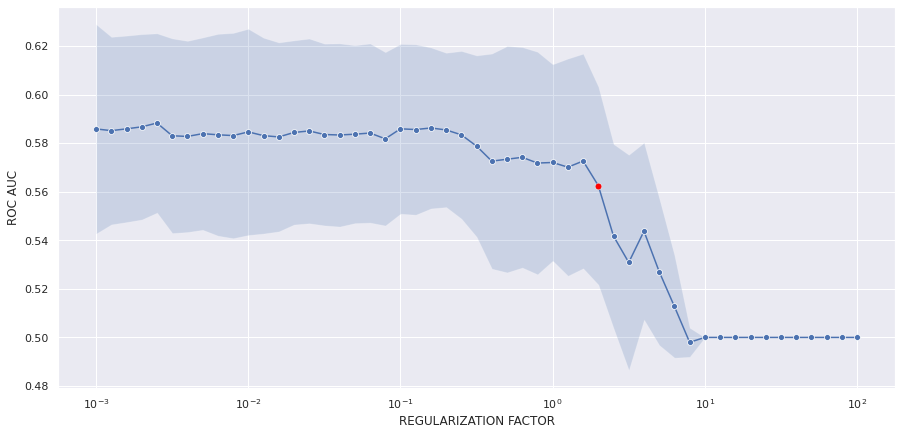

In [71]:
sns.set_theme()
plt.figure(figsize=(15,7))
ax = sns.lineplot(data=scores, x='c', y='score', ci=scores.std, markers=True, marker='o')
ax.fill_between(1/parameters['C'], y1=lasso_gs.cv_results_['mean_test_score'] - lasso_gs.cv_results_['std_test_score'], 
                y2=lasso_gs.cv_results_['mean_test_score'] + lasso_gs.cv_results_['std_test_score'], alpha=.2)
ax.set_xscale('log')
ax.set_ylabel('ROC AUC')
ax.set_xlabel('REGULARIZATION FACTOR')
#ax.set_title('Lasso LogisticRegression GridSearch')
plt.plot(1/parameters['C'][17],lasso_gs.cv_results_['mean_test_score'][17], 'ok', markersize=5, color='red')
plt.savefig('./Plots/GS_AD_rare_hemi.png', dpi=150)
#ax.set_ylim([0.475,0.7])

In [72]:
lasso_gs.best_estimator_

LogisticRegression(C=398.1071705534977, penalty='l1', random_state=1234,
                   solver='liblinear', verbose=1)

In [73]:
1/c[17]

1.9952623149688788

In [74]:
method_name = 'Lasso'

#lasso = lasso_gs.best_estimator_
lasso = LogisticRegression(C=c[17],penalty='l1',
                   random_state=1234, solver='liblinear', verbose=1)

xval_score = cross_val_score(lasso,X,y,cv=crossvalidation)

# compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

lasso.fit(X_nic,y_nic)

importances = lasso.coef_

prec = np.average(cross_val_score(lasso,X_nic,y_nic,cv=crossvalidation, scoring='precision'))
    
rec = np.average(cross_val_score(lasso,X_nic,y_nic,cv=crossvalidation, scoring='recall'))
    
f1_metric = np.average(cross_val_score(lasso,X_nic,y_nic,cv=crossvalidation, scoring='f1'))
    
auc_metric = np.average(cross_val_score(lasso,X_nic,y_nic,cv=crossvalidation, scoring='roc_auc'))


print('\n')    
print("%40s"%method_name)
print("========================================")
print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
print("\t      Precision %.3f"%prec)
print("\t      Recall    %.3f"%rec)
print("\t      F1        %.3f"%f1_metric)
print("\t      AUC        %.3f"%auc_metric)
print("\n")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

                                   Lasso
	  Accuracy (CV) 0.550 0.066
	      Precision 0.577
	      Recall    0.378
	      F1        0.453
	      AUC        0.563




In [75]:
importances = lasso.coef_.flatten()
importances.shape[0]

646

In [76]:
indices = np.argsort(np.absolute(importances))[::-1]#[0:100]
indices = indices[np.absolute(importances[indices])>0.000001]

In [77]:
selected_features = importances[indices]

In [78]:
len(selected_features)

59

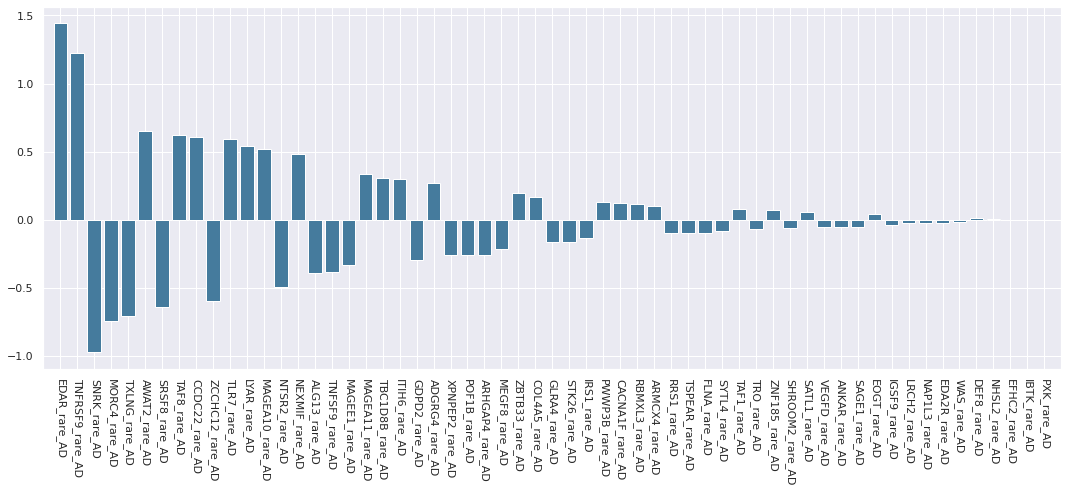

In [80]:
n_features = len(selected_features)

fig, ax = plt.subplots(figsize=(15,7))

#plt.title("Lasso Feature importances male rare AD")

ax.bar(range(n_features), importances[indices],
        color="#457b9d", yerr=None, align="center")

plt.xticks(range(n_features), X_nic.columns[indices],rotation='-90')
#ax.get_xticklabels()[1].set_fontweight("bold")
#ax.get_xticklabels()[4].set_fontweight("bold")
#ax.get_xticklabels()[16].set_fontweight("bold")

plt.xlim([-1, len(selected_features)])#X.shape[1]])
plt.tight_layout()
#plt.savefig('./Plots/Feature_importances_adjbyage.png',dpi=150)
plt.savefig('./Plots/Selected_AD_rare_hemi.png', dpi=150)
plt.show()

In [35]:
yp_cv = cross_val_predict(lasso, X, y, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Text(0.5, 1.0, 'Lasso Confusion Matrix')

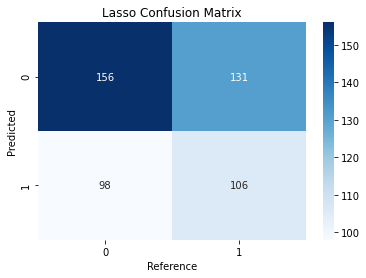

In [36]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Lasso Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])
#plt.savefig('./Plots/Lasso Confusion matrix adj by age.png', dpi=150)